# Chirp diagnostic
(see paper "Real-time chirp diagnostic for ultrashort laser pulses" (MOSAIC))

In [65]:
# Make plot in GUI
%matplotlib qt

In [66]:
# Make plots inline
%matplotlib inline

In [67]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import fftpack
from scipy import interpolate
from scipy import constants
from scipy import signal
import pickle

from datetime import datetime

Laser Wavelength in nm (Laser Frequency will be in THz therefore * $10^{-3})

In [68]:
wavelength_laser = 785
frequency_laser = constants.c / wavelength_laser * 10**(-3)

In [69]:
print("Frequenzy-Laser: %.02f THz" % frequency_laser)

Frequenzy-Laser: 381.90 THz


In [70]:
path = r"../../Data/Autocorrelator/" + "2019-03-22_13-11_ACF_Laser_direct_gauss_FWHM_208fs_785nm_1.5ps" + ".txt"

In [71]:
data = np.loadtxt(path)

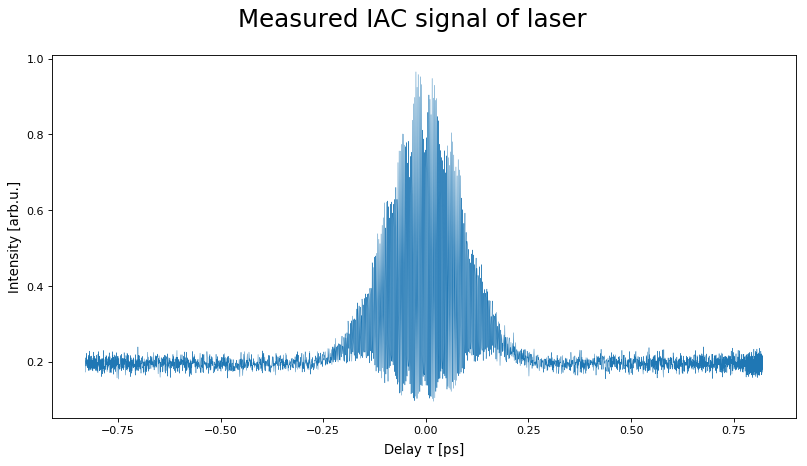

In [72]:
# Create a figure of size 8x6 inches, 80 dots per inch
plt.figure(figsize=(12, 6), dpi=80)
plt.suptitle('Measured IAC signal of laser', fontsize = 22)

plt.xlabel(r"Delay $\tau$ [ps]", fontsize = 12)
plt.ylabel(r"Intensity [arb.u.]", fontsize = 12)

plt.plot(data[:,0], data[:,1], linewidth=0.4)
plt.show()

## Interpolation

(Alternative with non-uniform FFT see https://github.com/jakevdp/nfft)

In [73]:
func_linear_interp = interpolate.interp1d(data[:,0], data[:,1])

### Nyquist Theorem:
Use at least twice the highest frequency of the signal to sample it.

Highest Frequency is 2 * frequency of laser = 382 (THz) (THz is just noted, the frequencies therefore need to be multiplied by THz to get the physical value)

Minimum sample frequency is therefore 763.

We choose a sample frequency of 10000.

The time step is therefore $10^{-5}$

In [74]:
# Time step in ps
time_step =  1 * 10**(-5)

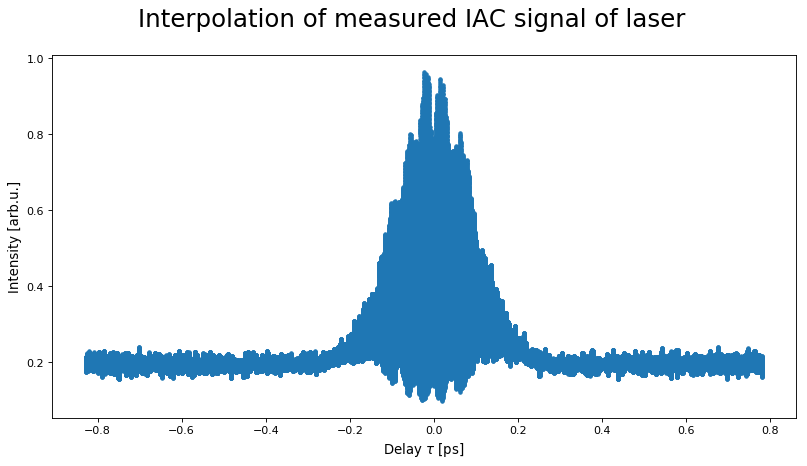

In [75]:
interpolation_time = np.arange(data[-1,0], data[0,0], time_step)
data_linear_interp = func_linear_interp(interpolation_time)

# Create a figure of size 8x6 inches, 80 dots per inch
plt.figure(figsize=(12, 6), dpi=80)

plt.suptitle('Interpolation of measured IAC signal of laser', fontsize = 22)

plt.xlabel(r"Delay $\tau$ [ps]", fontsize = 12)
plt.ylabel(r"Intensity [arb.u.]", fontsize = 12)

plt.plot(interpolation_time, data_linear_interp, ".")
plt.show()

## FFT
Transform interpolated signal into frequency-space per FFT.

In [76]:
# The FFT of the signal
data_fft = fftpack.fft(data_linear_interp)

# And the power (filtered_data_fft is of complex dtype)
data_power_shifted = np.fft.fftshift(np.abs(data_fft))

# The corresponding frequencies
sample_freq = fftpack.fftfreq(data_linear_interp.size, d=time_step)
sample_freq_shifted = np.fft.fftshift(sample_freq)

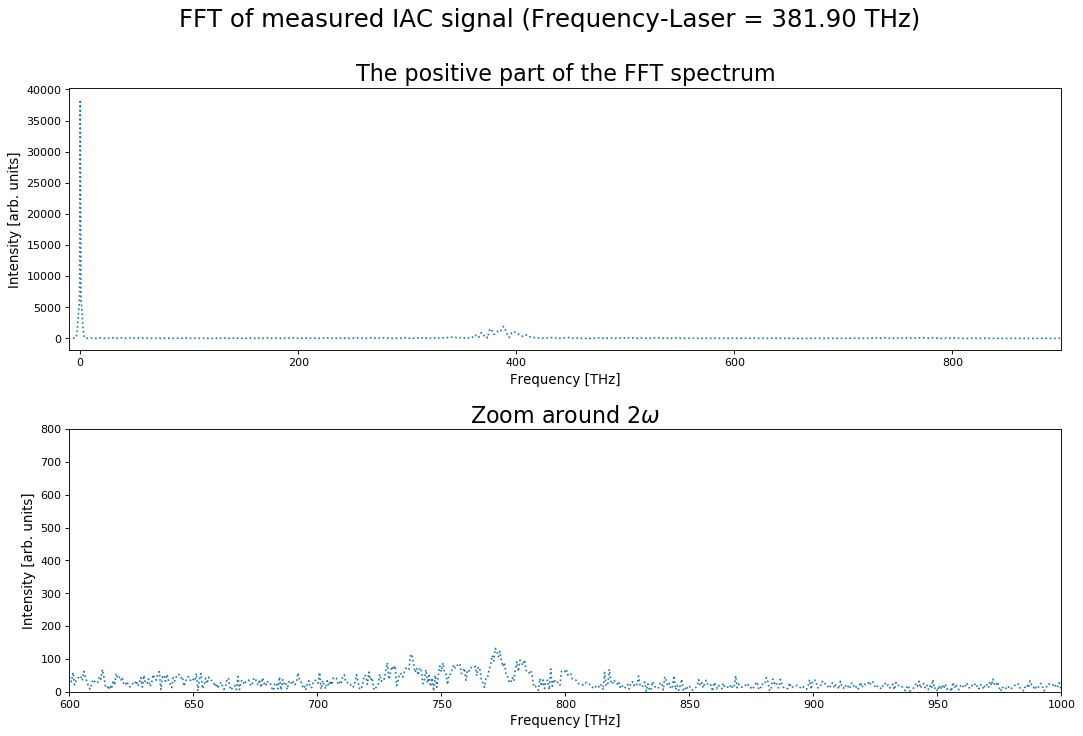

In [77]:
# Plot the FFT power
plt.figure(figsize=(16, 10), dpi=80)
plt.subplots_adjust(hspace = 0.3)
plt.suptitle('FFT of measured IAC signal (Frequency-Laser = %.02f THz)' % frequency_laser, fontsize = 22)

plt.subplot(211)
plt.title("The positive part of the FFT spectrum", fontsize = 20)
plt.xlabel('Frequency [THz]', fontsize = 12)
plt.ylabel('Intensity [arb. units]', fontsize = 12)
plt.xlim(-10, 900)
plt.plot(sample_freq_shifted, data_power_shifted, ":")

plt.subplot(212)
plt.title(r"Zoom around $2\omega$", fontsize = 20)
plt.xlabel('Frequency [THz]', fontsize = 12)
plt.ylabel('Intensity [arb. units]', fontsize = 12)
plt.xlim(600, 1000)
plt.ylim(0, 800)
plt.plot(sample_freq_shifted, data_power_shifted, ":")

plt.show()

## Implement Filter
Citation from MOSAIC paper:
"The bandpass filter functions were taken as rectangular functions centered at $\omega$
and $2\omega$ having bandwidths of $\omega$.

Alternative with "correct" filter implementations:

Scipy Signal Filter Tutorial (https://docs.scipy.org/doc/scipy/reference/tutorial/signal.html)

How many taps? (https://dsp.stackexchange.com/a/31210)

In [78]:
filtered_data_fft = data_fft.copy()

for i in range(data_fft.size):
    if frequency_laser * 0.5 < abs(sample_freq[i]) < frequency_laser * 1.5:
        filtered_data_fft[i] = 0
    if frequency_laser * 1.5 < abs(sample_freq[i]) < frequency_laser * 2.5:
        filtered_data_fft[i] = data_fft[i] * 2

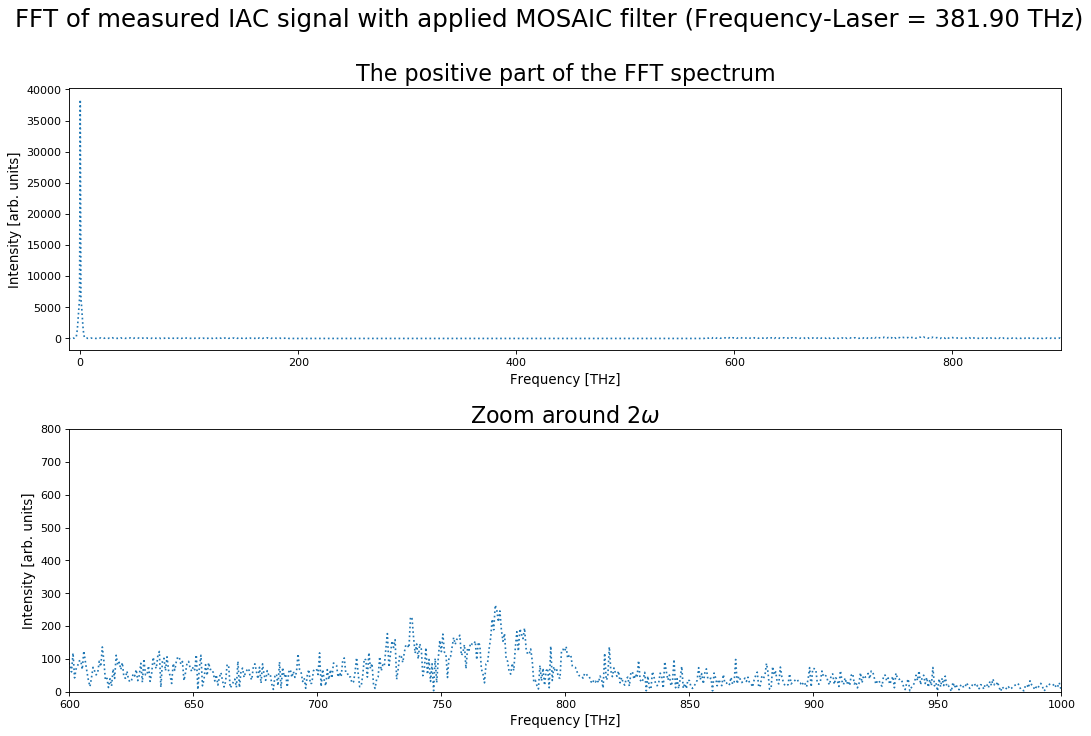

In [79]:
# And the power (filtered_data_fft is of complex dtype)
data_power_2_shifted = np.fft.fftshift(np.abs(filtered_data_fft))

# Plot the FFT power
plt.figure(figsize=(16, 10), dpi=80)
plt.subplots_adjust(hspace = 0.3)
plt.suptitle('FFT of measured IAC signal with applied MOSAIC filter (Frequency-Laser = %.02f THz)' % frequency_laser, fontsize = 22)

plt.subplot(211)
plt.title("The positive part of the FFT spectrum", fontsize = 20)
plt.xlabel('Frequency [THz]', fontsize = 12)
plt.ylabel('Intensity [arb. units]', fontsize = 12)
plt.xlim(-10, 900)
plt.plot(sample_freq_shifted, data_power_2_shifted, ":")

plt.subplot(212)
plt.title(r"Zoom around $2\omega$", fontsize = 20)
plt.xlabel('Frequency [THz]', fontsize = 12)
plt.ylabel('Intensity [arb. units]', fontsize = 12)
plt.xlim(600, 1000)
plt.ylim(0, 800)
plt.plot(sample_freq_shifted, data_power_2_shifted, ":")

plt.show()

## Inverse FFT
Transform filtered signal back into time-space per inverse FFT.

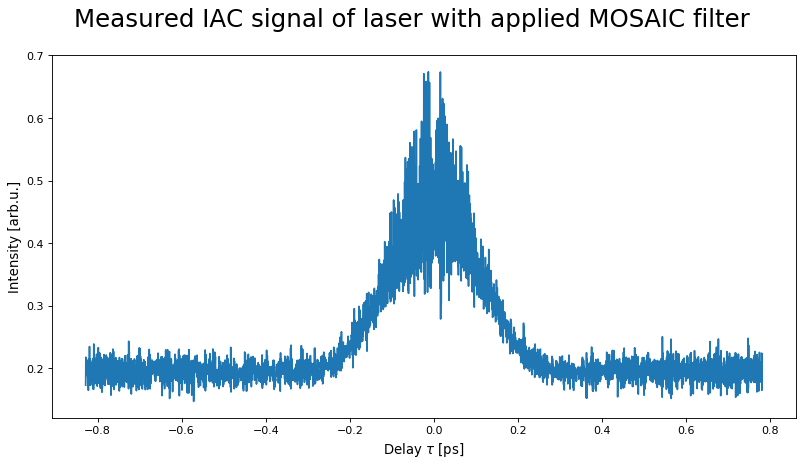

In [80]:
filtered_sig = np.real(fftpack.ifft(filtered_data_fft))

# Create a figure of size 8x6 inches, 80 dots per inch
plt.figure(figsize=(12, 6), dpi=80)
plt.suptitle('Measured IAC signal of laser with applied MOSAIC filter', fontsize = 22)

plt.xlabel(r"Delay $\tau$ [ps]", fontsize = 12)
plt.ylabel(r"Intensity [arb.u.]", fontsize = 12)

plt.plot(interpolation_time, filtered_sig)
plt.show()


Guess $\alpha$-value:

In [81]:
alpha_values = np.array([0.06])     

In [82]:
filepath =  r"../../Data/Autocorrelator/Simulation/"

In [83]:
laser_shape = "gauss"
tau_0_laser = 0.1


omega_laser = frequency_laser * 2 * np.pi

I_M_values = np.empty((interpolation_time.size, 1))
I_M_values[:, 0] = filtered_sig / np.mean(filtered_sig[0:30])

filename =  filepath + str(datetime.now()).replace(":", "_")     \
           + "_Autocorrelation_Measurement"             \
           + ".pkl"

with open(filename, 'wb') as file:
    pickle.dump(["measurement", laser_shape, interpolation_time, I_M_values,
                 tau_0_laser, omega_laser, alpha_values], file)